**Reference**: Keras tutorial : https://www.tensorflow.org/tutorials/generative/autoencoder

This file trains an autoencoder with the instances of the normal digit in the training data. 

Then, it measures the reconstruction loss for the digits in the test data.

The reconstruction loss for the instances of the abnormal digit in the test data is higher.

A threshold is determined based on the distribution of the reconstruction losses of the normal training data (threshold = mean + 2.5*std of this distribution).  

Then, if the reconstruction loss of a digit in the test data is higher than this threshold, it is classified as abnormal.

By comparing with the known labels of test data (with T for normal digit(s) and F for abnormal digit(s)), the confusion matrix and the accuracy is calculated. 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from keras import layers, losses
from keras.datasets import cifar10
from keras.models import Model
# import cv2

**Loading the MNIST data and forming arrays of the normal training data and the test data (normal and abnormal)**

In [15]:
nl1 = 3   # cat
nl2 = 3   # cat
abn = 8   # ship

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

x_train = x_train.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255

normal_data = x_train[(y_train == nl1).flatten() | (y_train == nl2).flatten()]    # Normal training data (cats)
normal_labels = y_train[(y_train == nl1).flatten() | (y_train == nl2).flatten()]

test_data = x_test[(y_test == abn).flatten() | (y_test == nl1).flatten() | (y_test == nl2).flatten()]   # Test data (ships)
test_labels = y_test[(y_test == abn).flatten() | (y_test == nl1).flatten() | (y_test == nl2).flatten()]

test_labels_T_F = np.where((test_labels == nl1).flatten() | (test_labels == nl2).flatten(), True, False) 
# Array of T and F, T where test digits are normal and F where test digits are abnormal

(5000, 32, 32, 3)


In [ ]:
normal_data.shape, test_data.shape, test_labels.shape

((5842, 28, 28), (1956, 28, 28), (1956,))

In [ ]:
normal_test_data = test_data[(test_labels == nl1) | (test_labels == nl2)]   # The normal digits in the test data
abnormal_test_data = test_data[test_labels == abn]                          # The abnormal digits in the test data
normal_test_labels = test_labels[(test_labels == nl1) | (test_labels == nl2)]   # Their labels
abnormal_test_labels = test_labels[test_labels == abn]                          # Their labels

In [ ]:
normal_test_data.shape, abnormal_test_data.shape

((982, 28, 28), (974, 28, 28))

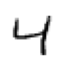

In [ ]:
# First normal digit
plt.figure(figsize=(1,1))
plt.imshow(normal_data[0], cmap="binary")
plt.axis('off')
plt.show()

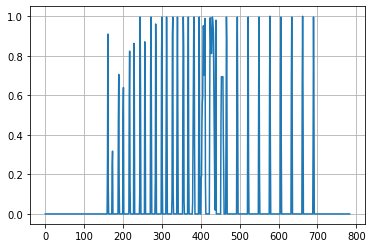

In [ ]:
# 1 dim plot of (flattened array of) first normal digit
plt.grid()
plt.plot(np.arange(28*28), normal_data[0].ravel())
plt.show()

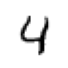

In [ ]:
# first test digit
plt.figure(figsize=(1,1))
plt.imshow(test_data[0], cmap="binary")
plt.axis('off')
plt.show()

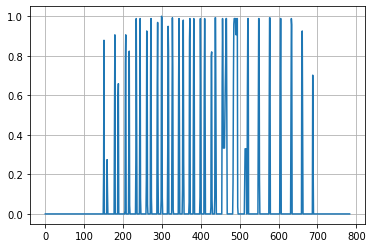

In [ ]:
# 1 dim plot of first test digit
plt.grid()
plt.plot(np.arange(28*28), test_data[0].ravel())
plt.show()

In [ ]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(128, activation="selu"),
      layers.Dense(64, activation="selu"),
      layers.Dense(32, activation="selu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(64, activation="selu"),
      layers.Dense(128, activation="selu"),
      layers.Dense(28*28, activation="sigmoid"),
      layers.Reshape((28, 28))])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [ ]:
# autoencoder.compile(optimizer='adam', loss='mae')
autoencoder.compile(optimizer='rmsprop', loss='binary_crossentropy')

In [ ]:
history = autoencoder.fit(normal_data, normal_data, 
          epochs=100, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/100
12/12 [==============================] - 320s 6s/step - loss: 0.4182 - val_loss: 0.2809
Epoch 2/100
12/12 [==============================] - 21s 2s/step - loss: 0.2258 - val_loss: 0.2685
Epoch 3/100
12/12 [==============================] - 27s 2s/step - loss: 0.2143 - val_loss: 0.2574
Epoch 4/100
12/12 [==============================] - 39s 3s/step - loss: 0.1999 - val_loss: 0.2431
Epoch 5/100
12/12 [==============================] - 29s 2s/step - loss: 0.1849 - val_loss: 0.2402
Epoch 6/100
12/12 [==============================] - 23s 2s/step - loss: 0.1744 - val_loss: 0.2353
Epoch 7/100
12/12 [==============================] - 18s 2s/step - loss: 0.1663 - val_loss: 0.2350
Epoch 8/100
12/12 [==============================] - 16s 1s/step - loss: 0.1614 - val_loss: 0.2310
Epoch 9/100
12/12 [==============================] - 17s 1s/step - loss: 0.1570 - val_loss: 0.2296
Epoch 10/100
12/12 [==============================] - 18s 2s/step - loss: 0.1516 - val_loss: 0.2292
Epoch 11

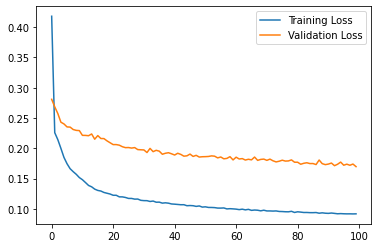

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

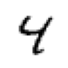

In [ ]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.figure(figsize=(1,1))
plt.imshow(normal_test_data[1], cmap="binary")
plt.axis('off')
plt.show()

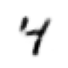

In [ ]:
plt.figure(figsize=(1,1))
plt.imshow(decoded_data[1], cmap="binary")
plt.axis('off')
plt.show()

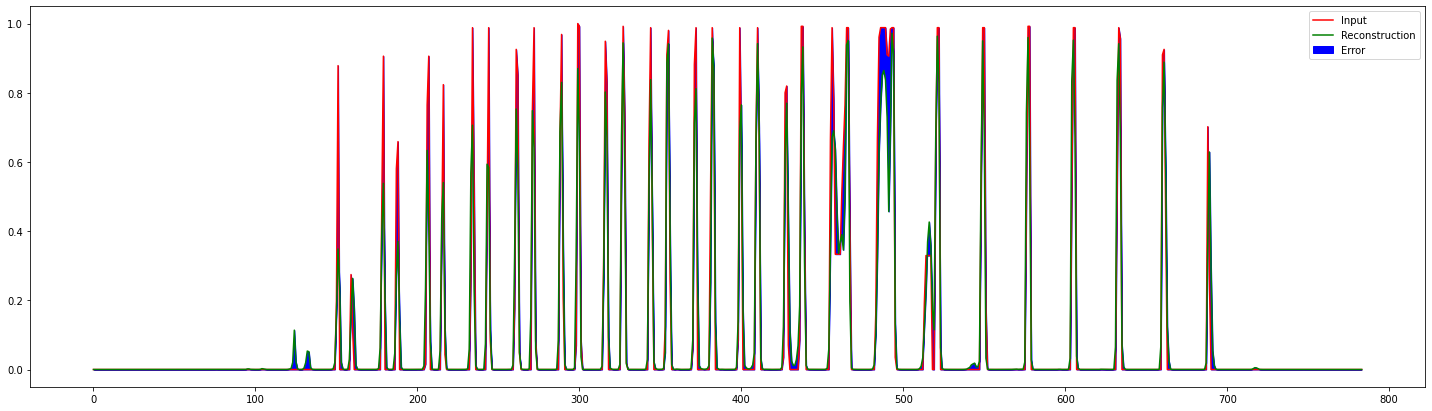

In [ ]:
plt.figure(figsize=(25,7))
plt.plot(normal_test_data[0].ravel(), 'r')
plt.plot(decoded_data[0].ravel(), 'g')
plt.fill_between(np.arange(28*28), decoded_data[0].ravel(), normal_test_data[0].ravel(), color='blue')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

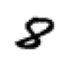

In [ ]:
encoded_abn_data = autoencoder.encoder(abnormal_test_data).numpy()
decoded_abn_data = autoencoder.decoder(encoded_abn_data).numpy()

plt.figure(figsize=(1,1))
plt.imshow(abnormal_test_data[0], cmap="binary")
plt.axis('off')
plt.show()

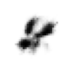

In [ ]:
plt.figure(figsize=(1,1))
plt.imshow(decoded_abn_data[0], cmap="binary")
plt.axis('off')
plt.show()

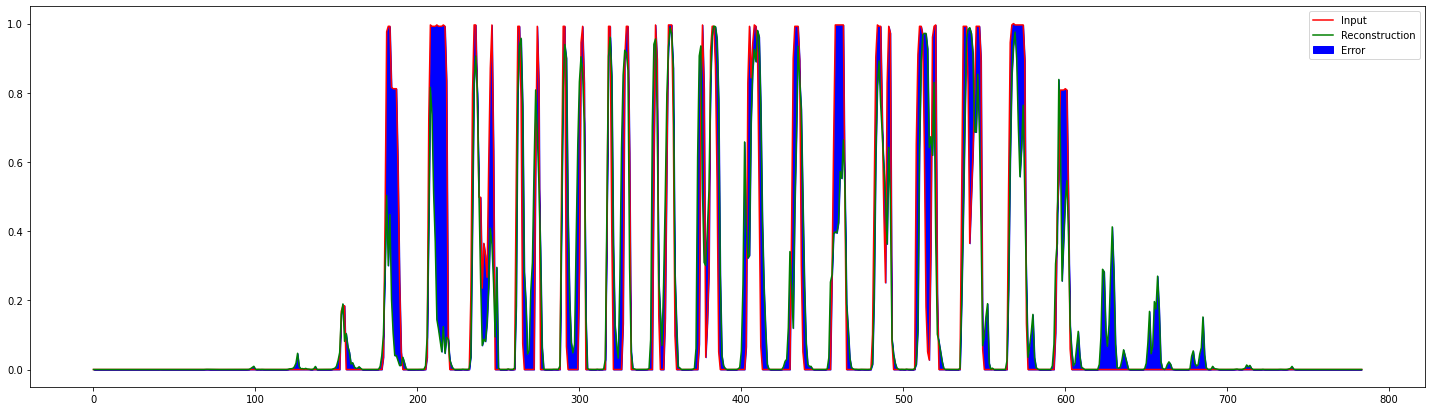

In [ ]:
plt.figure(figsize=(25,7))
plt.plot(abnormal_test_data[0].ravel(), 'r')
plt.plot(decoded_abn_data[0].ravel(), 'g')
plt.fill_between(np.arange(28*28), decoded_abn_data[0].ravel(), abnormal_test_data[0].ravel(), color='blue')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

**Distribution of the reconstruction losses of the normal training data**

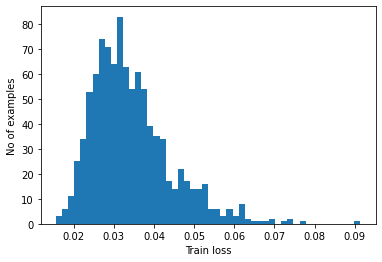

In [ ]:
reconstructions = autoencoder.predict(normal_data)
train_loss = tf.keras.losses.mae(reconstructions.reshape(-1, 784), normal_data.reshape(-1, 784))
plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
print("Mean: ", np.mean(train_loss))
print("Std: ", np.std(train_loss))

Mean:  0.03437823
Std:  0.009884496


In [ ]:
threshold1 = np.mean(train_loss) + 2.5*np.std(train_loss)
print("Threshold1: ", threshold1)

Threshold1:  0.059089471120387316


**Distribution of the reconstruction losses of the abnormal test data**

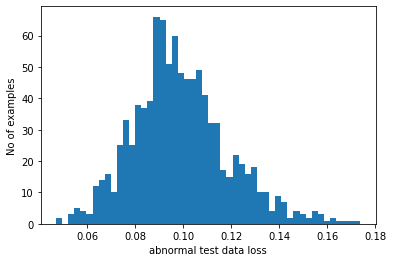

In [ ]:
reconstructions = autoencoder.predict(abnormal_test_data)
abn_test_loss = tf.keras.losses.mae(reconstructions.reshape(-1,784), abnormal_test_data.reshape(-1,784))

plt.hist(abn_test_loss[None, :], bins=50)
plt.xlabel("abnormal test data loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
# threshold2 = np.mean(abn_test_loss) - np.std(abn_test_loss)
# print("Threshold2: ", threshold2)

In [ ]:
np.mean(abn_test_loss) , np.std(abn_test_loss)

(0.09902078, 0.019971311)

**Threshold will be threshold1 = mean + std of the distribution of the reconstruction losses of the normal training data**

In [ ]:
threshold = threshold1

**Calculation of the confusion matrix**

In [ ]:
def predict(model, data, threshold):
  reconstructions = model.predict(data)
  loss = tf.keras.losses.mae(reconstructions.reshape(-1, 784), data.reshape(-1, 784))
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  cf = confusion_matrix(labels, predictions)
  print("Confusion Matrix: \n prediction: F      T ")
  print("             {}   {}".format(preds[preds == False].shape[0], preds[preds == True].shape[0]))
  print(" label: F   [[{}   {}]    {}".format(cf[0,0], cf[0,1], test_labels_T_F[test_labels_T_F == False].shape[0]))
  print("        T    [{}   {}]]   {}".format(cf[1,0], cf[1,1], test_labels_T_F[test_labels_T_F == True].shape[0]))
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [ ]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels_T_F)

Confusion Matrix: 
 prediction: F      T 
             988   968
 label: F   [[961   13]    974
        T    [27   955]]   982
Accuracy = 0.9795501022494888
Precision = 0.9865702479338843
Recall = 0.9725050916496945


In [ ]:
print(confusion_matrix(test_labels_T_F, preds))

[[961  13]
 [ 27 955]]


**Distribution of the reconstruction losses of the test data (normal and abnormal)**

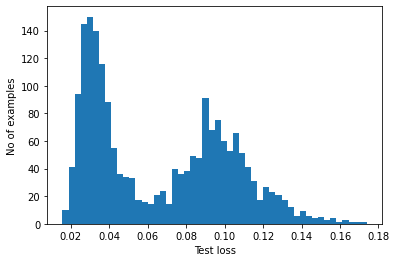

In [ ]:
reconstructions = autoencoder.predict(test_data)
test_loss = tf.keras.losses.mae(reconstructions.reshape(-1,784), test_data.reshape(-1,784))

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()